In [2]:
##Import library and read data
import numpy as np 
import os,csv
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
import pandas as pd
import os

os.chdir(r"c:\Users\trivi\Documents\Winter2024Courses\BIEN462\Parkinsons\csvdata") # CHANGE THIS TO YOUR CSV DIRECTORY
directory = os.getcwd()
alldata = []
start = 0
getall = True
threshold = 7
filenames = []

if getall:
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            patient = open(filename)
            read= list(csv.reader(patient))
            data = np.array(read).astype(float)
            alldata.append(data)
            filenames.append(f[-13:-4])
else:
    patient = open("GaCo01_01.csv")
    read = list(csv.reader(patient))
    data = np.array(read).astype(float)
    alldata.append(data)
    patient = open("GaPt03_01.csv")
    read = list(csv.reader(patient))
    data = np.array(read).astype(float)
    alldata.append(data)
#print(alldata[0])

In [3]:
#FFT 
#Welch PSD
def find(val,arr):
    return np.argmin(np.abs(arr-val))

N=8192
allharmonics = np.zeros((len(filenames),8,3))
for i,feature in enumerate(alldata):
    for sensor in range(8):
        xf, yf = signal.welch(feature[500:8692,sensor+2],100,"hamming",nperseg=N/4,nfft=N)
        #Find peaks
        peaks, properties = signal.find_peaks(20*np.log(yf[:500]), prominence = 70)
        # Get ratio of harmonics vs fundamental amplitude
        fundamental = (yf[peaks[0]])
        fundfreq = xf[peaks[0]]
        #print(peaks)
        allharmonics[i,sensor] = [20*np.log((yf[find(fundfreq*2,xf[peaks[0]:500])+peaks[0]])/fundamental),
                             20*np.log((yf[find(fundfreq*3,xf[peaks[0]:500])+peaks[0]])/fundamental),
                             20*np.log((yf[find(fundfreq*4,xf[peaks[0]:500])+peaks[0]])/fundamental)]


In [47]:
#Writing Data to file
rows = ["Patient,2nd1S,3rd1S,4th1S,2nd2S,3rd2S,4th2S,2nd3S,3rd3S,4th3S,2nd4S,3rd4S,4th4S,2nd5S,3rd5S,4th5S,2nd6S,3rd6S,4th6S,2nd7S,3rd7S,4th7S,2nd8S,3rd8S,4th8S,Disease"]
for n, l in enumerate(allharmonics):
    line = [filenames[n]]
    strline = ''
    for o in l:
        for m in o:
            line.append(str(m))
    if "Pt" in line[0]:
        line.append("1")
    else:
        line.append("0")
    rows.append(','.join(line))
text = "\n".join(rows) 
with open('harmonics/features3.csv', 'w') as f: 
    f.write(text)



c:\Users\trivi\Documents\Winter2024Courses\BIEN462\Parkinsons\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8382352941176471


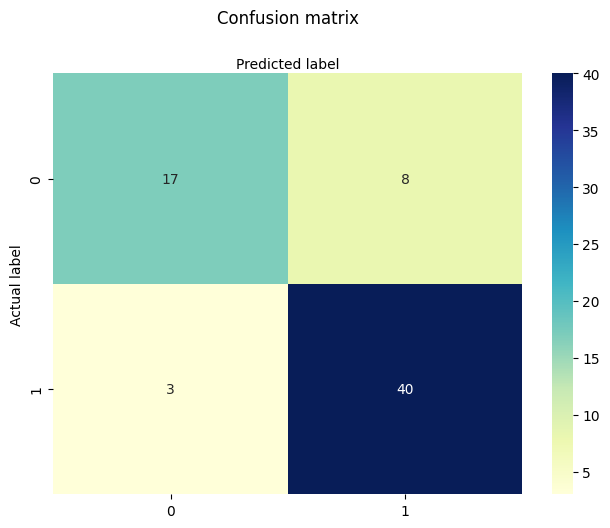

In [4]:
#Load data into pandas dataframe
features= pd.read_csv("Harmonics/features3.csv")
### X are the variables that predict and y the variable we are trying to predict.
X=features[['2nd1S','3rd1S','4th1S','2nd2S','3rd2S','4th2S','2nd3S','3rd3S','4th3S','2nd4S','3rd4S','4th4S','2nd5S','3rd5S','4th5S','2nd6S','3rd6S','4th6S','2nd7S','3rd7S','4th7S','2nd8S','3rd8S','4th8S']]
y=features[['Disease']]

### The data has to be divided in training and test set.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

### Data Normalization
from sklearn.preprocessing import StandardScaler
ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

###We import the model that will be used.
from sklearn.linear_model import LogisticRegression
# Create an instance of the model.
logreg = LogisticRegression()
# Training the model.
logreg.fit(X_train,y_train)
# Do prediction.
y_pred=logreg.predict(X_test)

# Analyzing the results
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Libraries used for plots and arrays.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))